In [ ]:
!pip install yfinance ta scikit-fuzzy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.5 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ff8dae6b975c9e2ac83e4f374db92aba556262d42d7b828d32c75c2e78be0cd6
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
#  IMPORT LIBRARIES
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import datetime
import ta

In [ ]:
#  STEP 1: DOWNLOAD DATA
stock = 'GOOGL'
df = yf.download(stock, start='2015-01-01', end='2024-12-31')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
df

Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2015-01-02,26.351515,26.662528,26.268410,26.503287,26480000
2015-01-05,25.849413,26.273884,25.764321,26.232084,41182000
2015-01-06,25.211466,25.936498,25.157225,25.901167,54456000
2015-01-07,25.137320,25.452811,25.062678,25.425941,46918000
2015-01-08,25.224901,25.254260,24.633228,24.956185,73054000
...,...,...,...,...,...
2024-12-23,194.406113,194.875573,189.931255,192.398415,25675000
2024-12-24,195.884399,195.884399,193.557078,194.615856,10403300


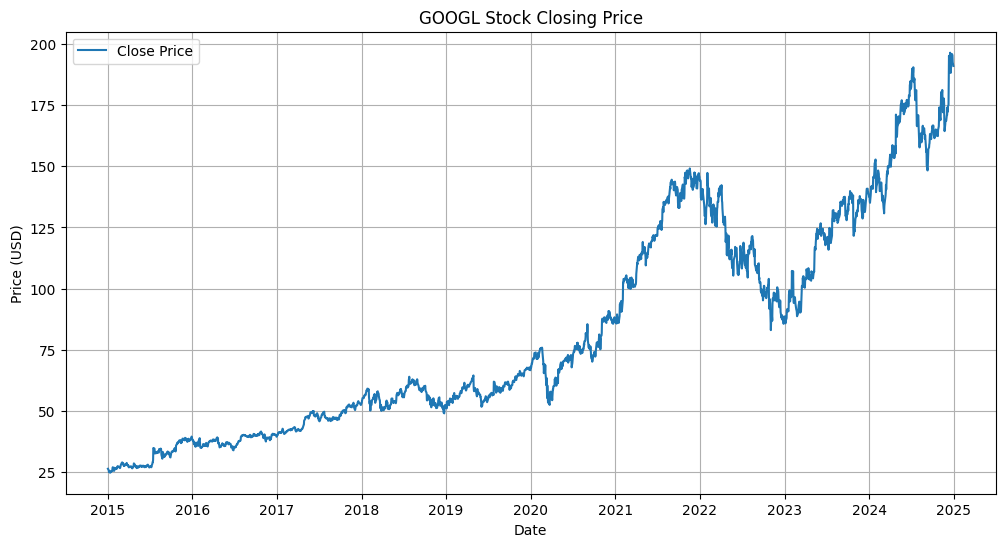

In [ ]:
# INITIAL PLOT
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.title(f'{stock} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
ma_100_days = df.Close.rolling(100).mean()  #Moving Averages --> Based on history of data we estimate stock prize

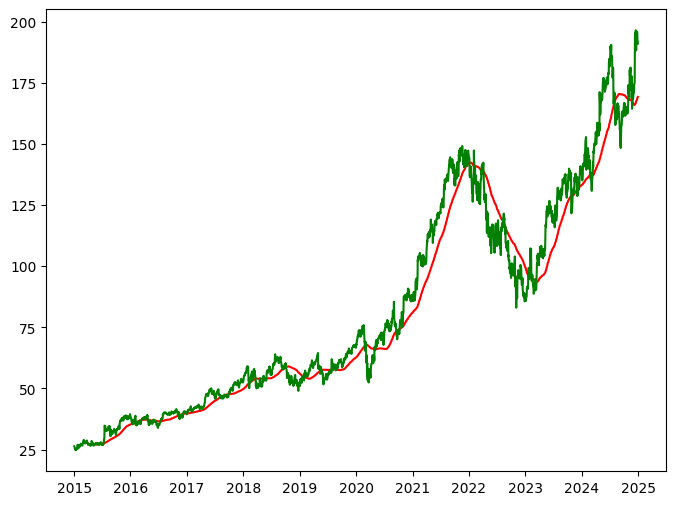

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days,'r')
plt.plot(df.Close,'g')
plt.show()

In [ ]:
ma_200_days = df.Close.rolling(200).mean()

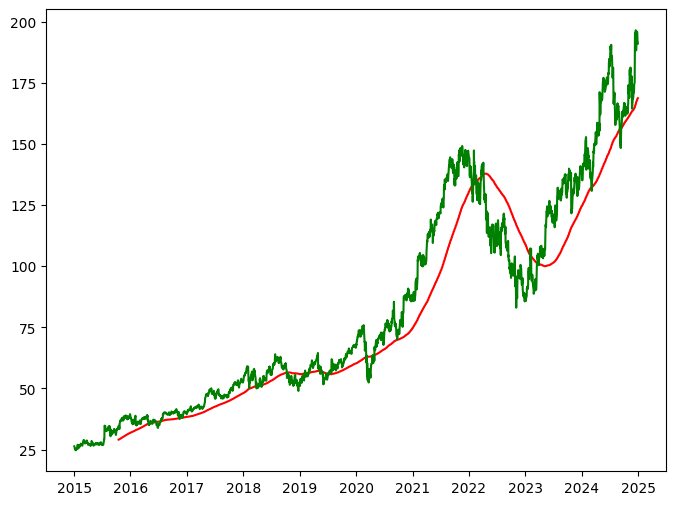

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(ma_200_days,'r')
plt.plot(df.Close,'g')
plt.show()

In [ ]:
print("\nMissing Values Before Cleaning:\n", df.isnull().sum())


Missing Values Before Cleaning:
 Price   Ticker
Close   GOOGL     0
High    GOOGL     0
Low     GOOGL     0
Open    GOOGL     0
Volume  GOOGL     0
dtype: int64


In [ ]:
import ta
import numpy as np

# STEP: Create Series from DataFrame (extract Series properly)
close = df['Close'].values  # Convert to 1D numpy array
# OR use this approach instead:
close = df['Close'].squeeze()  # Convert to pandas Series
high = df['High'].squeeze()
low = df['Low'].squeeze()
volume = df['Volume'].squeeze()

# RSI
rsi_indicator = ta.momentum.RSIIndicator(close=close)
df['RSI'] = rsi_indicator.rsi()

# MACD
macd_indicator = ta.trend.MACD(close=close)
df['MACD'] = macd_indicator.macd_diff()

# OBV (manual calculation)
df['OBV'] = 0.0
df.loc[:, 'OBV'] = np.where(df['Close'].diff() > 0, df['Volume'],
                    np.where(df['Close'].diff() < 0, -df['Volume'], 0)).cumsum()

# ADX
adx_indicator = ta.trend.ADXIndicator(high=high, low=low, close=close)
df['ADX'] = adx_indicator.adx()

# Fill any missing values
df[['RSI', 'MACD', 'OBV', 'ADX']] = df[['RSI', 'MACD', 'OBV', 'ADX']].fillna(method='bfill').fillna(method='ffill')

<ipython-input-11-2b800930dffb>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['RSI', 'MACD', 'OBV', 'ADX']] = df[['RSI', 'MACD', 'OBV', 'ADX']].fillna(method='bfill').fillna(method='ffill')


In [ ]:
# STEP 2: PREPROCESSING
data = df[['Close']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

lookback = 60
X, y = [], []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

In [ ]:
# Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# STEP 3: BUILD LSTM MODEL
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer='adam',                  # Or 'sgd', but adam usually performs better for LSTM
    loss='mean_squared_error'
        )        # Good for regression tasks like price prediction




# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    # callbacks=[early_stop],
    # verbose=1
)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0146 - val_loss: 0.0037
Epoch 2/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0015 - val_loss: 9.7756e-04
Epoch 3/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 9.9487e-04 - val_loss: 0.0011
Epoch 6/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 9.0321e-04 - val_loss: 0.0037
Epoch 9/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 9.5025e-04 - val_loss: 0.0021
Epoch 10/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 9.5069e-04 - val_loss: 0.0013
Epoch 11/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 8.5643e-04 - val_loss: 9.9676e-04
Epoch 12/25
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms

In [ ]:
# STEP 4: PREDICTIONS & EVALUATION
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"RMSE: {rmse:.2f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
RMSE: 4.33


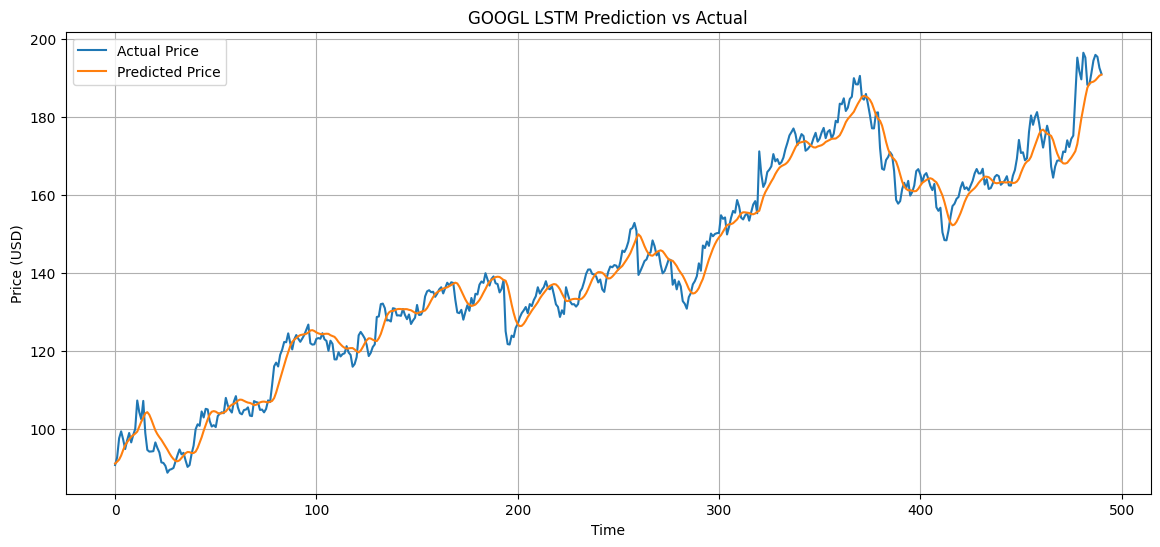

In [ ]:
# Plot prediction
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title(f'{stock} LSTM Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl

def create_fuzzy_system(df):
    """
    Creates a simplified yet effective fuzzy logic trading system
    with adjusted membership functions and balanced rules
    """
    # Define fuzzy variables with appropriate universes
    rsi = ctrl.Antecedent(np.arange(0, 101, 1), 'rsi')
    macd = ctrl.Antecedent(np.arange(-5, 5.1, 0.1), 'macd')

    # Dynamic range for OBV based on historical data
    obv_min = df['OBV'].min()
    obv_max = df['OBV'].max()
    obv_range = np.linspace(obv_min, obv_max, 1000)
    obv = ctrl.Antecedent(obv_range, 'obv')

    adx = ctrl.Antecedent(np.arange(0, 101, 1), 'adx')

    # Output variable with wider range for more differentiated results
    action = ctrl.Consequent(np.arange(0, 2.01, 0.01), 'action')



    # RSI - Clear distinctions between categories
    rsi['oversold'] = fuzz.trapmf(rsi.universe, [0, 0, 25, 35])
    rsi['neutral'] = fuzz.trapmf(rsi.universe, [30, 40, 60, 70])
    rsi['overbought'] = fuzz.trapmf(rsi.universe, [65, 75, 100, 100])

    # MACD - Clearer separation
    macd['negative'] = fuzz.trapmf(macd.universe, [-5, -5, -1, 0])
    macd['neutral'] = fuzz.trimf(macd.universe, [-0.5, 0, 0.5])
    macd['positive'] = fuzz.trapmf(macd.universe, [0, 1, 5, 5])

    # OBV - Simpler categories
    obv_mid = (obv_min + obv_max) / 2
    obv_quarter = (obv_max - obv_min) / 4

    obv['low'] = fuzz.trapmf(obv.universe, [obv_min, obv_min, obv_mid - obv_quarter, obv_mid])
    obv['neutral'] = fuzz.trimf(obv.universe, [obv_mid - obv_quarter, obv_mid, obv_mid + obv_quarter])
    obv['high'] = fuzz.trapmf(obv.universe, [obv_mid, obv_mid + obv_quarter, obv_max, obv_max])

    # ADX - Simplified
    adx['weak_trend'] = fuzz.trapmf(adx.universe, [0, 0, 20, 30])
    adx['moderate_trend'] = fuzz.trimf(adx.universe, [20, 35, 50])
    adx['strong_trend'] = fuzz.trapmf(adx.universe, [40, 60, 100, 100])

    # Action - Better distributed output categories
    action['strong_sell'] = fuzz.trapmf(action.universe, [0, 0, 0.3, 0.5])
    action['sell'] = fuzz.trimf(action.universe, [0.3, 0.5, 0.7])
    action['hold'] = fuzz.trimf(action.universe, [0.6, 1.0, 1.4])
    action['buy'] = fuzz.trimf(action.universe, [1.3, 1.5, 1.7])
    action['strong_buy'] = fuzz.trapmf(action.universe, [1.5, 1.7, 2, 2])

    # Simplified rule set with less overlap
    rules = [
        # Strong Buy signals
        ctrl.Rule(rsi['oversold'] & macd['positive'] & adx['strong_trend'], action['strong_buy']),
        ctrl.Rule(rsi['oversold'] & macd['positive'] & obv['high'], action['strong_buy']),

        # Buy signals
        ctrl.Rule(rsi['oversold'] & macd['neutral'], action['buy']),
        ctrl.Rule(rsi['neutral'] & macd['positive'] & adx['moderate_trend'], action['buy']),
        ctrl.Rule(macd['positive'] & obv['high'] & adx['moderate_trend'], action['buy']),

        # Hold signals
        ctrl.Rule(rsi['neutral'] & macd['neutral'], action['hold']),
        ctrl.Rule(obv['neutral'] & adx['weak_trend'], action['hold']),
        ctrl.Rule(rsi['neutral'] & obv['neutral'], action['hold']),

        # Sell signals
        ctrl.Rule(rsi['overbought'] & macd['neutral'], action['sell']),
        ctrl.Rule(rsi['neutral'] & macd['negative'] & adx['moderate_trend'], action['sell']),
        ctrl.Rule(macd['negative'] & obv['low'] & adx['moderate_trend'], action['sell']),

        # Strong Sell signals
        ctrl.Rule(rsi['overbought'] & macd['negative'] & adx['strong_trend'], action['strong_sell']),
        ctrl.Rule(rsi['overbought'] & macd['negative'] & obv['low'], action['strong_sell']),
    ]

    # Create control system and simulation
    control_system = ctrl.ControlSystem(rules)
    fuzzy_sim = ctrl.ControlSystemSimulation(control_system)

    return fuzzy_sim

In [ ]:
def make_trading_decision(fuzzy_output, current_price, predicted_price):
    """
    Make trading decisions based primarily on fuzzy output
    with price prediction as a secondary factor
    """
    # Calculate predicted price change percentage
    price_change_pct = ((predicted_price - current_price) / current_price) * 100

    # Decision logic with more emphasis on fuzzy output
    if fuzzy_output >= 1.5:  # Strong buy territory
        return "STRONG BUY"
    elif 1.2 <= fuzzy_output < 1.5:  # Buy territory
        return "BUY"
    elif 1.0 <= fuzzy_output < 1.2:  # Weak buy / upper neutral
        if price_change_pct > 1:
            return "BUY"
        else:
            return "HOLD (Buy Bias)"
    elif 0.8 <= fuzzy_output < 1.0:  # Lower neutral
        if price_change_pct < -1:
            return "HOLD (Sell Bias)"
        else:
            return "HOLD"
    elif 0.5 <= fuzzy_output < 0.8:  # Sell territory
        return "SELL"
    else:  # Strong sell territory
        return "STRONG SELL"


In [ ]:
def test_trading_system(df):
    """
    Tests the fuzzy system with several input scenarios to verify it produces
    different trading recommendations
    """
    fuzzy_sim = create_fuzzy_system(df)

    # Test scenarios
    test_scenarios = [
        {
            "name": "Bullish Scenario",
            "inputs": {"rsi": 25, "macd": 2.0, "obv": df['OBV'].quantile(0.75), "adx": 55},
            "price": 200,
            "prediction": 210
        },
        {
            "name": "Bearish Scenario",
            "inputs": {"rsi": 75, "macd": -2.0, "obv": df['OBV'].quantile(0.25), "adx": 55},
            "price": 200,
            "prediction": 190
        },
        {
            "name": "Neutral Scenario",
            "inputs": {"rsi": 50, "macd": 0.1, "obv": df['OBV'].median(), "adx": 25},
            "price": 200,
            "prediction": 202
        }
    ]

    print("\n=== TESTING TRADING SYSTEM ===")
    for scenario in test_scenarios:
        # Set inputs
        for key, value in scenario["inputs"].items():
            fuzzy_sim.input[key] = float(value)

        # Compute fuzzy output
        fuzzy_sim.compute()
        fuzzy_output = fuzzy_sim.output['action']

        # Get decision
        decision = make_trading_decision(
            fuzzy_output,
            scenario["price"],
            scenario["prediction"]
        )

        # Print results
        print(f"\n--- {scenario['name']} ---")
        print(f"Inputs: RSI={scenario['inputs']['rsi']}, MACD={scenario['inputs']['macd']}, ADX={scenario['inputs']['adx']}")
        print(f"Current Price: ${scenario['price']:.2f}")
        print(f"Predicted Price: ${scenario['prediction']:.2f}")
        print(f"Price Change: {((scenario['prediction']-scenario['price'])/scenario['price']*100):.2f}%")
        print(f"Fuzzy Output: {fuzzy_output:.2f}")
        print(f"Recommended Action: {decision}")


In [ ]:
# Create the fuzzy system
fuzzy_sim = create_professional_fuzzy_system(df)

# Get the latest indicators from dataset
latest = df.iloc[-1]

# Take current price as user input
current_price = float(input("Enter the current stock price: ₹"))

# Predict next price with LSTM
lstm_input = X[-1].reshape(1, lookback, 1)
predicted_price = scaler.inverse_transform(model.predict(lstm_input))[0][0]

# Feed fuzzy inputs from dataset
fuzzy_sim.input['rsi'] = float(latest['RSI'])
fuzzy_sim.input['macd'] = float(latest['MACD'])
fuzzy_sim.input['obv'] = float(latest['OBV'])
fuzzy_sim.input['adx'] = float(latest['ADX'])
fuzzy_sim.compute()

fuzzy_output = fuzzy_sim.output['action']

# Get detailed trading decision
decision = make_trading_decision(fuzzy_output, current_price, predicted_price)

# Print output with extracted float values
rsi_val = float(latest['RSI'])
macd_val = float(latest['MACD'])
obv_val = float(latest['OBV'])
adx_val = float(latest['ADX'])

print(f"\n=== TRADING DECISION ===")
print(f"RSI: {rsi_val:.2f}, MACD: {macd_val:.2f}, OBV: {obv_val:.2f}, ADX: {adx_val:.2f}")
print(f"User Input Price: ₹{current_price:.2f}")
# print(f"LSTM Predicted Price: ₹{predicted_price:.2f}")
# print(f"Price Change: {((predicted_price-current_price)/current_price*100):.2f}%")
print(f"Fuzzy Logic Score: {fuzzy_output:.2f}")
print(f"Recommended Action: {decision}")

Enter the current stock price: ₹999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

=== TRADING DECISION ===
RSI: 58.24, MACD: -0.01, OBV: 5090596100.00, ADX: 29.28
User Input Price: ₹999.00
Fuzzy Logic Score: 1.00
Recommended Action: HOLD (Buy Bias)


<ipython-input-59-bd372cb8e43b>:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fuzzy_sim.input['rsi'] = float(latest['RSI'])
<ipython-input-59-bd372cb8e43b>:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fuzzy_sim.input['macd'] = float(latest['MACD'])
<ipython-input-59-bd372cb8e43b>:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fuzzy_sim.input['obv'] = float(latest['OBV'])
<ipython-input-59-bd372cb8e43b>:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fuzzy_sim.input['adx'] = float(latest['ADX'])
<ipython-input-59-bd372cb8e43b>:27: FutureWarning: Calling float on a single element Serie

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def evaluate_lstm_trading_signals(model, X_test, y_test, scaler, threshold=0.01):
    # Get predictions
    y_pred_scaled = model.predict(X_test)

    # Convert to actual prices
    if len(y_pred_scaled.shape) == 2 and y_pred_scaled.shape[1] == 1:
        y_pred_scaled = y_pred_scaled.reshape(-1, 1)
        y_test_reshaped = y_test.reshape(-1, 1)
    else:
        y_test_reshaped = y_test

    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler.inverse_transform(y_test_reshaped).flatten()

    # Calculate percent changes
    y_true_pct = np.diff(y_true) / y_true[:-1]
    y_pred_pct = np.diff(y_pred) / y_pred[:-1]

    # Convert to binary signals (1 for up, 0 for down)
    y_true_signal = (y_true_pct > 0).astype(int)
    y_pred_signal = (y_pred_pct > 0).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_true_signal, y_pred_signal)
    prec = precision_score(y_true_signal, y_pred_signal, zero_division=0)
    rec = recall_score(y_true_signal, y_pred_signal, zero_division=0)


    print("\nModel Performance Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")

    return acc, prec, rec

Model Performance Metrics:
Accuracy: 0.7231
Precision: 0.7140
Recall: 0.6632
